In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX

## Fit a target function

In [33]:
def target_function(x, degree=3):
    result = 0
    for i in range(degree):
        result += torch.cos(i*x) + torch.sin(i*x)
    return .05 * result

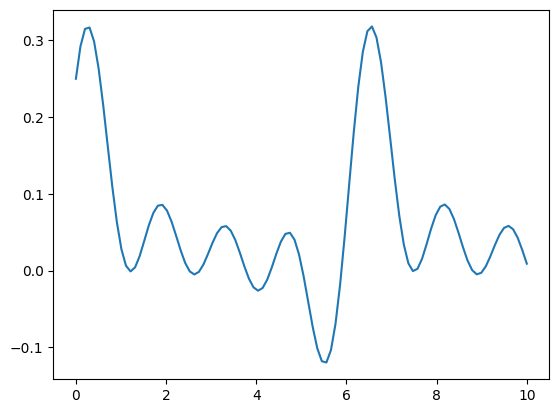

In [34]:
x = torch.tensor(np.linspace(0, 10, 100))
target_y = target_function(x, 5)
plt.plot(x.numpy(), target_y.numpy())

In [35]:
# make a quantum circuit
qc = QuantumCircuit(2)

# an initial state
print(qc.init_state(1))
print()
print(qc.init_state(3))

# apply ansatz onto initial state
AlternateLayerAnsatz(2, 2)(qc.init_state(3))

tensor([[[1.+0.j],
         [0.+0.j]],

        [[0.+0.j],
         [0.+0.j]]], dtype=torch.complex128)

tensor([[[1.+0.j, 1.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]], dtype=torch.complex128)


tensor([[[-0.1186+0.9256j, -0.1186+0.9256j, -0.1186+0.9256j],
         [ 0.0160+0.0019j,  0.0160+0.0019j,  0.0160+0.0019j]],

        [[ 0.0333+0.3090j,  0.0333+0.3090j,  0.0333+0.3090j],
         [-0.1171+0.1367j, -0.1171+0.1367j, -0.1171+0.1367j]]],
       dtype=torch.complex128, grad_fn=<PermuteBackward0>)

In [36]:
class Model(QuantumCircuit):
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers)
        self.embedding = SingleLayerEncoding(n_qubits)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)
        
        
    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)
        
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        
        new_state = Z(state, [0], self.n_qubits)
        
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))
        
        return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

In [37]:
n_qubits = 5
n_layers = 3
model = Model(n_qubits, n_layers)

In [38]:
with torch.no_grad():
    y = model(x)

In [39]:
model(x[0:10]).shape

torch.Size([10])

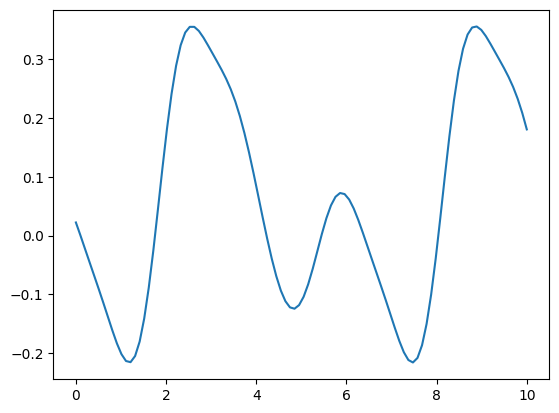

In [40]:
plt.plot(x.numpy(), y.numpy())

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
epochs = 200

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 0.053308524799426694
Epoch 2 | Loss 0.03788839437275628
Epoch 3 | Loss 0.02563667754018986
Epoch 4 | Loss 0.01672317214806103
Epoch 5 | Loss 0.010972505086006789
Epoch 6 | Loss 0.007858429736328752
Epoch 7 | Loss 0.006634751913796909
Epoch 8 | Loss 0.006565483814016171
Epoch 9 | Loss 0.007029611480867637
Epoch 10 | Loss 0.007576179716812745
Epoch 11 | Loss 0.007928105635373545
Epoch 12 | Loss 0.007959264087898951
Epoch 13 | Loss 0.007663567984580371
Epoch 14 | Loss 0.007116709457547998
Epoch 15 | Loss 0.006436943943740871
Epoch 16 | Loss 0.005751462435204242
Epoch 17 | Loss 0.005169477365731329
Epoch 18 | Loss 0.004761383928462777
Epoch 19 | Loss 0.004545362536950686
Epoch 20 | Loss 0.004486486015695662
Epoch 21 | Loss 0.0045125080468667225
Epoch 22 | Loss 0.004542471556136896
Epoch 23 | Loss 0.004514967771945983
Epoch 24 | Loss 0.004403068925964268
Epoch 25 | Loss 0.004212598220793993
Epoch 26 | Loss 0.0039698665443865045
Epoch 27 | Loss 0.0037074314704967125
Epoch 28 |

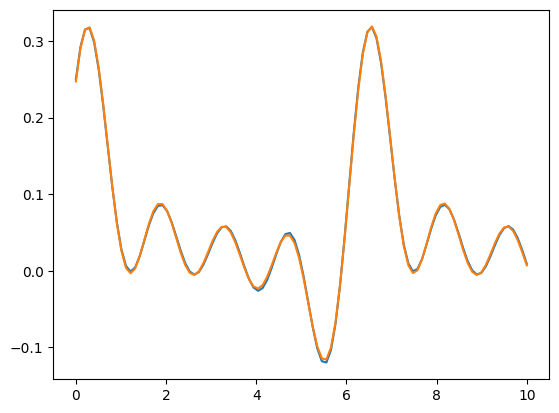

In [42]:
with torch.no_grad():
    y = model(x)

plt.plot(x.numpy(), target_y.numpy())    
plt.plot(x.numpy(), y.numpy())

## Solve MIS for QAOA

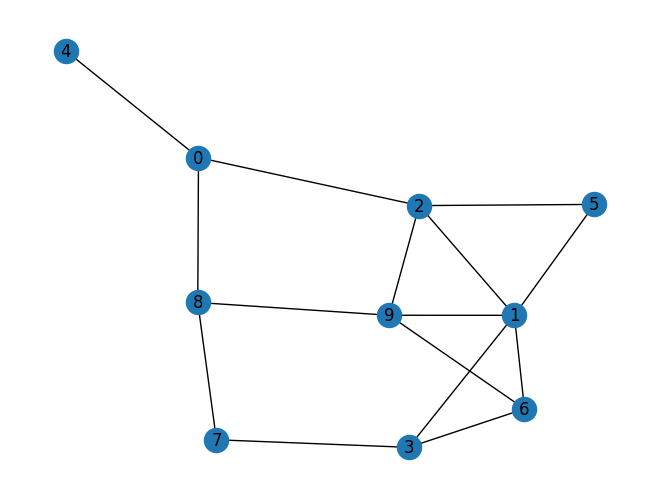

In [14]:
n_nodes = 10

graph = nx.gnp_random_graph(n_nodes, .25, seed=42)
nx.draw(graph, with_labels=True)

In [15]:
from pyqtorch.matrices import generate_ising_from_graph, sum_N
ising_matrix = generate_ising_from_graph(graph, type_ising='N')
ising_cost = 1.2*ising_matrix - sum_N(n_nodes)

ising_matrix = ising_matrix.reshape([2] * n_nodes + [1])
ising_cost = ising_cost.reshape([2] * n_nodes + [1])


class MIS(QuantumCircuit):
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.beta = nn.Parameter(torch.empty(n_layers,))
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        self.reset_parameters()
        
    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
        
    def forward(self, return_cost=False):
        state = self.uniform_state()
        for b, g in zip(self.beta, self.gamma):
            state = state * torch.exp(-1j * g * ising_matrix)
            for i in range(self.n_qubits):
                state = RX(b, state, [i], self.n_qubits)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * ising_cost))
        else:
            state = state.reshape((2**self.n_qubits,))
            return torch.abs(state)**2

In [16]:
model = MIS(n_nodes, 20)

optimizer = torch.optim.Adam(model.parameters(), lr=.02)
epochs = 500


for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model(True)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss -0.5137316834706246
Epoch 2 | Loss -0.5928422807145123
Epoch 3 | Loss -0.6486558291647003
Epoch 4 | Loss -0.6948649760120654
Epoch 5 | Loss -0.7384197730737164
Epoch 6 | Loss -0.7741694563616458
Epoch 7 | Loss -0.7985563382758075
Epoch 8 | Loss -0.817259111397848
Epoch 9 | Loss -0.8342768979104926
Epoch 10 | Loss -0.850464361472511
Epoch 11 | Loss -0.8625899250464136
Epoch 12 | Loss -0.8720621769623285
Epoch 13 | Loss -0.8832267722713467
Epoch 14 | Loss -0.8962235248126902
Epoch 15 | Loss -0.908738918670355
Epoch 16 | Loss -0.9204760698984794
Epoch 17 | Loss -0.9324937388440911
Epoch 18 | Loss -0.943753920442124
Epoch 19 | Loss -0.9536533770457982
Epoch 20 | Loss -0.9622249952399836
Epoch 21 | Loss -0.9691410869817084
Epoch 22 | Loss -0.9746999043572039
Epoch 23 | Loss -0.9801882532737921
Epoch 24 | Loss -0.986231513936134
Epoch 25 | Loss -0.9923461735746526
Epoch 26 | Loss -0.9976217994888168
Epoch 27 | Loss -1.0015708286280898
Epoch 28 | Loss -1.0046707997658832
Epoch 

Epoch 227 | Loss -1.158036112397309
Epoch 228 | Loss -1.1580226624848171
Epoch 229 | Loss -1.1580272994896388
Epoch 230 | Loss -1.1580431132150146
Epoch 231 | Loss -1.1580722143821114
Epoch 232 | Loss -1.1581062909977513
Epoch 233 | Loss -1.1581557183901072
Epoch 234 | Loss -1.1582092097251948
Epoch 235 | Loss -1.1582837203562621
Epoch 236 | Loss -1.158366076038431
Epoch 237 | Loss -1.1584566777911096
Epoch 238 | Loss -1.158546840611157
Epoch 239 | Loss -1.1586365356410724
Epoch 240 | Loss -1.1587204074704056
Epoch 241 | Loss -1.1587955268336363
Epoch 242 | Loss -1.158854817148979
Epoch 243 | Loss -1.1589048224340155
Epoch 244 | Loss -1.1589434198633377
Epoch 245 | Loss -1.1589684988051383
Epoch 246 | Loss -1.1589894507606333
Epoch 247 | Loss -1.159011233548807
Epoch 248 | Loss -1.1590345531049175
Epoch 249 | Loss -1.1590582631837136
Epoch 250 | Loss -1.1590795177959903
Epoch 251 | Loss -1.1591001844998217
Epoch 252 | Loss -1.1591221753510021
Epoch 253 | Loss -1.1591449245903087
Epoch 

Epoch 452 | Loss -1.1596275752977925
Epoch 453 | Loss -1.1596277193402917
Epoch 454 | Loss -1.1596257728017523
Epoch 455 | Loss -1.1596285035828138
Epoch 456 | Loss -1.159626791129325
Epoch 457 | Loss -1.1596288636170593
Epoch 458 | Loss -1.1596259469879309
Epoch 459 | Loss -1.1596273920326101
Epoch 460 | Loss -1.1596282620072602
Epoch 461 | Loss -1.159628182168572
Epoch 462 | Loss -1.159627773626415
Epoch 463 | Loss -1.159628785557304
Epoch 464 | Loss -1.1596266428820399
Epoch 465 | Loss -1.1596290221489145
Epoch 466 | Loss -1.1596286206049429
Epoch 467 | Loss -1.1596258310859544
Epoch 468 | Loss -1.1596280043468836
Epoch 469 | Loss -1.1596305615674163
Epoch 470 | Loss -1.159627497889078
Epoch 471 | Loss -1.1596251065271925
Epoch 472 | Loss -1.15962810710861
Epoch 473 | Loss -1.1596318129785317
Epoch 474 | Loss -1.159631233618338
Epoch 475 | Loss -1.1596316135649942
Epoch 476 | Loss -1.1596277760118125
Epoch 477 | Loss -1.1596280997267183
Epoch 478 | Loss -1.1596274182605495
Epoch 479

In [17]:
prob = model()
mis = torch.argmax(prob)
format(mis, '010b')

'1000111110'

In [18]:
mis

tensor(574)

In [19]:
"{0:b}".format(1)

'1'

In [20]:
sum_N(n_nodes)[mis]

tensor(6.+0.j, dtype=torch.complex128)